In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from PIL import Image 
from torchvision.transforms import v2
import random
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [2]:
df_info = pd.read_csv('C:\\Machine learning\\Data sets\\simpsons\\number_pic_char.csv')

df_info.iloc[:20, 1:]

,name,total,train,test,bounding_box
0,Homer Simpson,2246,1909,337,612
1,Ned Flanders,1454,1236,218,595
2,Moe Szyslak,1452,1234,218,215
3,Lisa Simpson,1354,1151,203,562
4,Bart Simpson,1342,1141,201,554
5,Marge Simpson,1291,1097,194,557
6,Krusty The Clown,1206,1025,181,226
7,Principal Skinner,1194,1015,179,506
8,Charles Montgomery Burns,1193,1014,179,650
9,Milhouse Van Houten,1079,917,162,210


In [3]:
char_to_label = {}
label_to_char = {}

for character in df_info.loc[:19, 'name']:
    character = character.lower().replace(' ', '_')
    label = len(char_to_label.items())
    char_to_label[character] = label
    label_to_char[label] = character

In [4]:
with open('C:\\Machine learning\\Data sets\\simpsons\\annotation.txt', 'r') as f:
    lines = f.readlines()

base_path = 'C:\Machine learning\Data sets\simpsons'

for line in lines:
    image_path, x1, y1, x2, y2, character = line.split(',')
    
    path = os.path.join(base_path, image_path[2:].replace('/', '\\'))
    print(path, x1, y1, x2, y2, character)
    break    

len(lines)

C:\Machine learning\Data sets\simpsons\characters\abraham_grampa_simpson\pic_0000.jpg 57 72 52 72 abraham_grampa_simpson



6752

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:

class SimpsonsDataset(Dataset):
    
    def __init__(self, annotation_file, base_path, char_to_label, transform=None, augmentation=None, max_limit = 1000):
        self.base_path = base_path
        self.transform = transform
        self.augmentation = augmentation
        self.data = []
        self.max_limit = max_limit
        
        self.data_count = {}
        
        self.char_to_label = char_to_label
        
        with open(annotation_file) as f:
            lines = f.readlines()

        for line in lines:
            image_path, x1, y1, x2, y2, character = line.split(',')
            character = character.strip()
            
            character = self.char_to_label[character]
            
            if(not self.data_count.__contains__(character)):
                self.data_count[character] =1
                
            else:
                if(self.data_count[character] > self.max_limit):
                    continue
                
                if(self.data_count.__contains__(character)):
                    self.data_count[character] +=1
                
            full_path = os.path.join(base_path, image_path[2:].replace('/', '\\'))
            img = Image.open(full_path).convert('RGB')
            
            self.data.append({
                'image': img,
                'bbox': [float(x1), float(y1), float(x2), float(y2)],
                'character': character
            })
        
        if self.augmentation != None:
            self.augment_dataset()
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        img = item['image']
        bbox = item['bbox']
        
        if self.transform:
            img = self.transform(img)
        
        item['character'] = torch.tensor(item['character'])
        
        return img.to(device), torch.tensor(bbox).to(device), item['character'].to(device)

    def augment_dataset(self):
        augmented_data = []
        
        for item in self.data:
            
            while (self.data_count[item['character']] < self.max_limit):
                aug_img, aug_bbox = self.apply_augmentations(item['image'], item['bbox'])
                augmented_data.append({
                    'image': aug_img,
                    'bbox': aug_bbox,
                    'character': item['character']
                })
                
                self.data_count[item['character']] += 1
                
        self.data.extend(augmented_data)


    def apply_augmentations(self, img, bbox):
        bbox = list(bbox)
        
        if random.random() > 0.5:
            img = v2.functional.hflip(img)
            bbox[0], bbox[2] = 1 - bbox[2], 1 - bbox[0]
        
        img = self.augmentation(img)
        return img, bbox
    
    def get_count(self):
        return self.data_count

In [7]:
augmentation = v2.Compose([
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            v2.RandomRotation(degrees=15),
            v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33))
        ])

transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

        
base_path = 'C:\\Machine learning\\Data sets\\simpsons'
annotation_file = 'C:\\Machine learning\\Data sets\\simpsons\\annotation.txt'

train_dataset = SimpsonsDataset(annotation_file, base_path, char_to_label, transform=transform, augmentation=augmentation)

c:\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
num_classes = len(train_dataset.get_count())

len(train_dataset), len(train_dataset.get_count())

(18000, 18)

In [9]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class SimpsonModel(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.act2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.act4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 30 * 30, 512)
        self.act5 = nn.ReLU()
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.batch_norm_1(x)
        x = self.act5(x)
        x = self.drop3(x)
        x = self.fc2(x)
        
        return x

### Training

In [25]:
model = SimpsonModel(num_classes).to(device)

ud    = []
lossi = []

**HyperParameters**

In [26]:
len(train_dataloader.dataset)/batch_size

70.3125

In [27]:
lr = 1e-3
epochs = 9

In [28]:
# Load the pretrained model

model.load_state_dict(torch.load('simpsonsModel.pth', weights_only=True))

<All keys matched successfully>

In [136]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = AdamW(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.9)

# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0.0
    
#     for i, (img, bbox, char) in enumerate(train_dataloader):

#         output = model(img)
#         char = char.to(device)

#         optimizer.zero_grad()
#         loss = loss_fn(output, char)

#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#         with torch.no_grad():
#             lossi.append(loss.log10().item())
#             ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])
    
#     avg_loss = epoch_loss / len(train_dataloader)
#     print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.10f}")
    
#     scheduler.step()
#     current_lr = optimizer.param_groups[0]['lr']
#     print(f"Current Learning Rate: {current_lr}")

Epoch 1 completed. Average Loss: 0.8845436892
Current Learning Rate: 0.001


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27100\2321207472.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['character'] = torch.tensor(item['character'])


Epoch 2 completed. Average Loss: 0.4955521822
Current Learning Rate: 0.001
Epoch 3 completed. Average Loss: 0.3031495711
Current Learning Rate: 0.0009000000000000001
Epoch 4 completed. Average Loss: 0.1555619065
Current Learning Rate: 0.0009000000000000001
Epoch 5 completed. Average Loss: 0.0732844630
Current Learning Rate: 0.0009000000000000001
Epoch 6 completed. Average Loss: 0.0392449836
Current Learning Rate: 0.0008100000000000001
Epoch 7 completed. Average Loss: 0.0212924663
Current Learning Rate: 0.0008100000000000001
Epoch 8 completed. Average Loss: 0.0114441151
Current Learning Rate: 0.0008100000000000001
Epoch 9 completed. Average Loss: 0.0084465840
Current Learning Rate: 0.000729


1e-2 , AdamW 0.00014945391740184277
1e-3 , AdamW 0.0007138152723200619



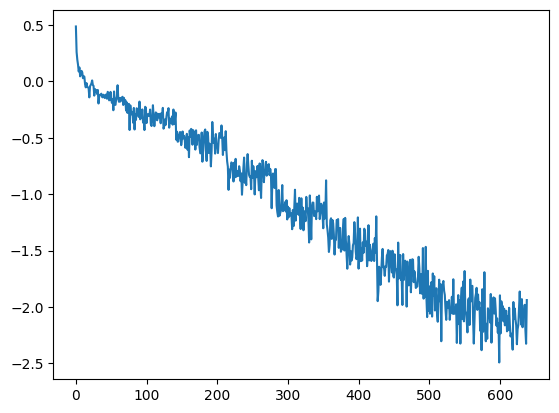

In [137]:
plt.plot(lossi)

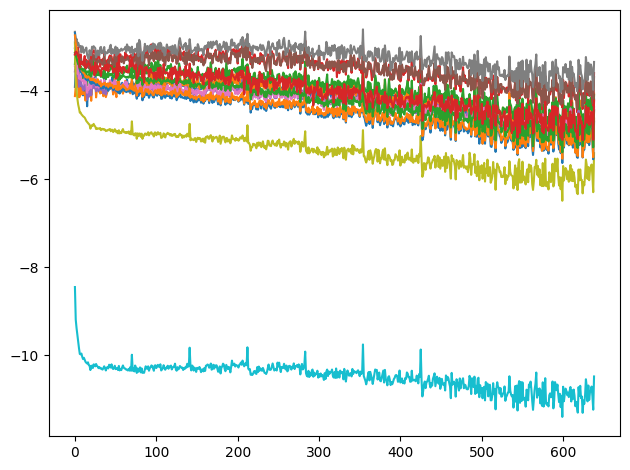

In [138]:
plt.plot(ud)
plt.tight_layout()
plt.show()

In [15]:
class SimpsonsTestDataset(Dataset):
    
    def __init__(self, base_path, transform):
        super().__init__()
        self.dataset = []
        self.transform = transform
        
        self.class_names = []
        
        image_names = os.listdir(base_path)
        
        for name in image_names:
            full_path = os.path.join(base_path, name)
            image = Image.open(full_path).convert('RGB')
            
            name = self.clean_image_name(name)
            
            if(name=='mayor_quimby' or name == 'lenny_leonard'):
                continue
            
            self.class_names.append(name)
            
            self.dataset.append({
                'img' : image,
                'name': name
            })
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item['img']
        img = self.transform(img)
    
        char = item['name']
        return img.to(device), char_to_label[char]
    
    def __len__(self):
        return len(self.dataset)
    
    def get_class_names(self):
        return set(self.class_names)
    
    def clean_image_name(self, name):
        parts = name.split('_')
        base_name = '_'.join(parts[:-1])  
        return base_name

In [16]:
test_base_path = 'C:\Machine learning\Data sets\simpsons\kaggle_simpson_testset\kaggle_simpson_testset'


test_dataset = SimpsonsTestDataset(test_base_path, transform)

In [124]:
len(test_dataset), len(test_dataset.get_class_names())

(890, 18)

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [29]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    amount = 0
    for (img, chars) in dataloader:
        logits = model(img)
        
        pred = torch.argmax(logits, dim=1)
        
        chars = list(chars.detach().numpy())
        
        count = (pred.cpu().detach().numpy() == chars).sum()
        
        correct += count
        amount  += len(chars)
        
    return (correct / amount)

acc = evaluate(test_dataloader)

print(f'Test Accuracy = {acc:.2f}')

Test Accuracy = 0.83


**Test Accuracy = 0.83**

In [141]:
# Save the model

# torch.save(model.state_dict(), 'simpsonsModel.pth')

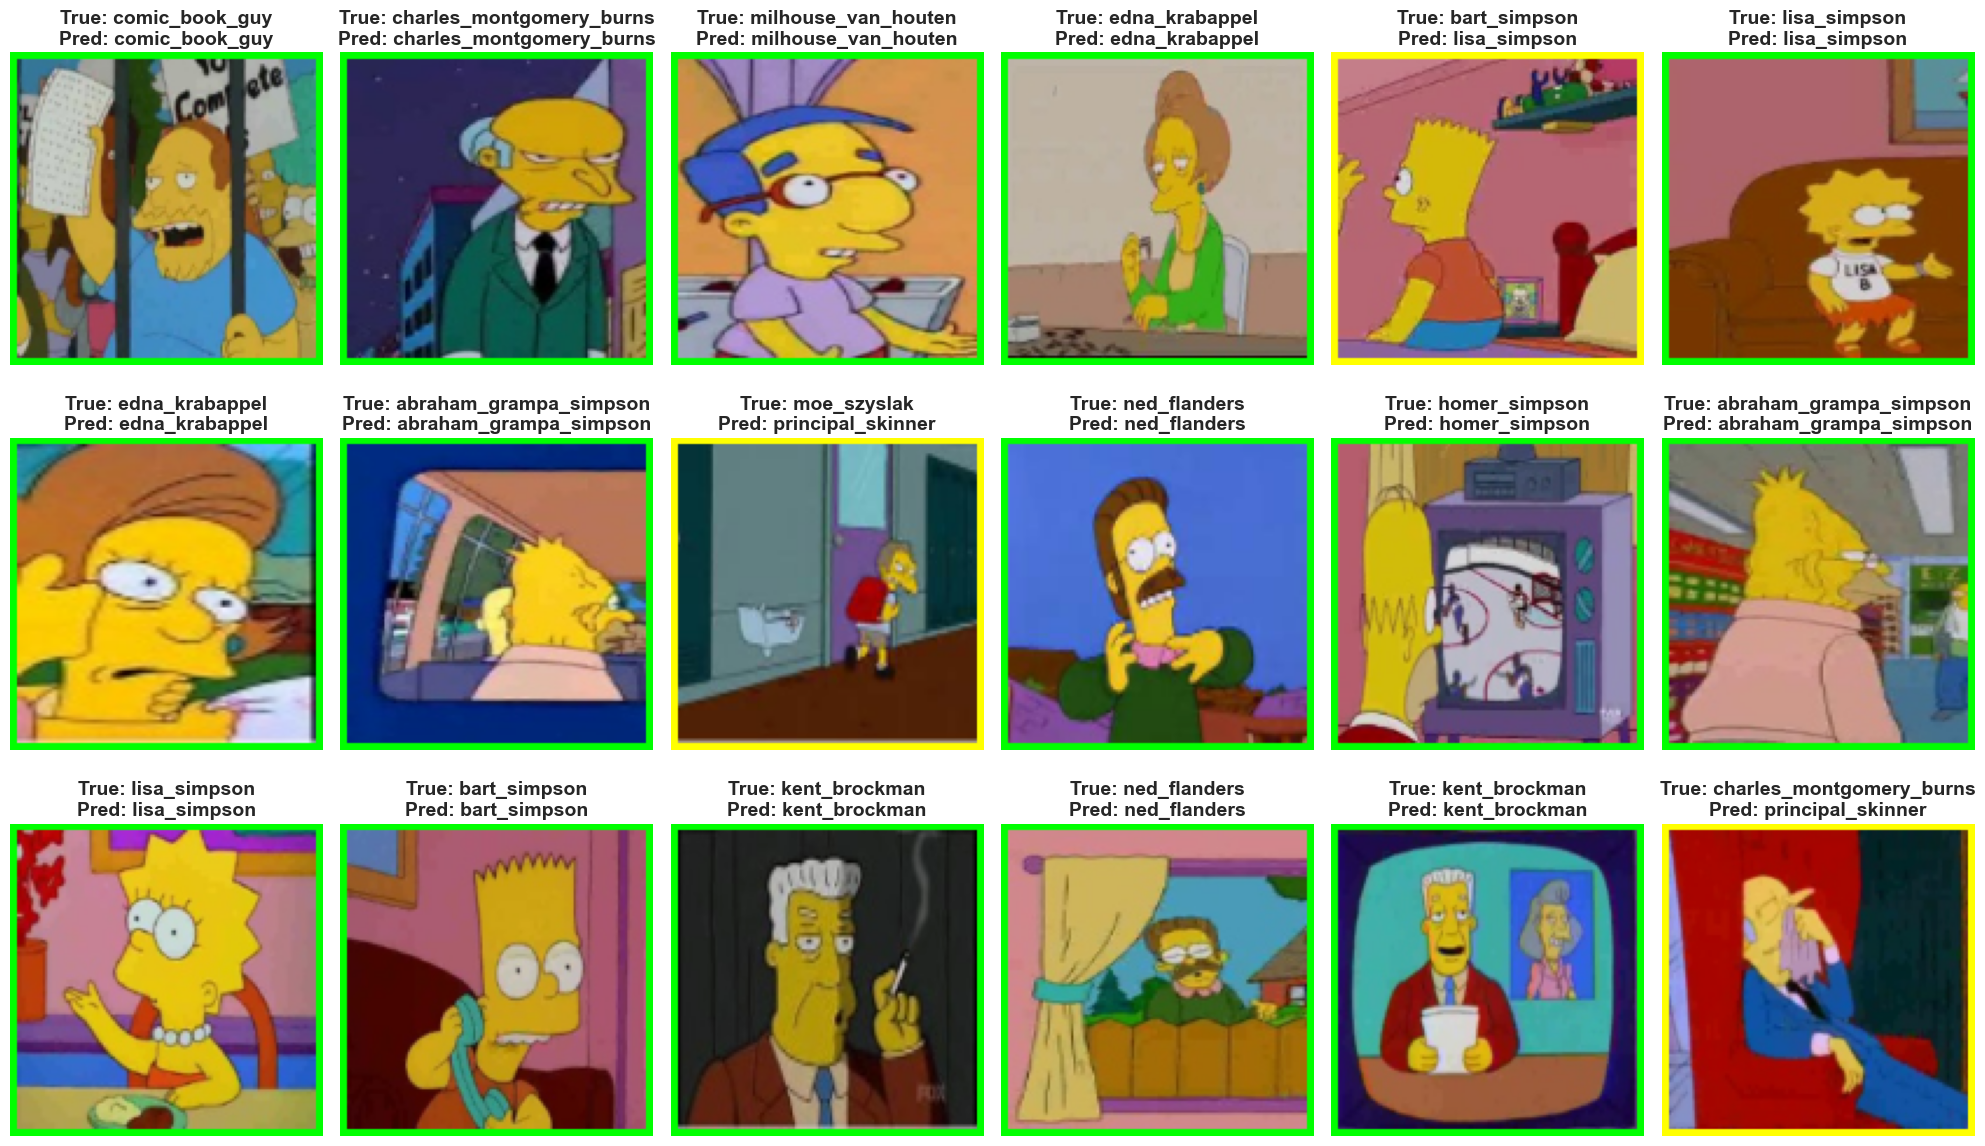

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    
    mean = mean.to(device)
    std = std.to(device)
    
    return tensor * std + mean

def show_model_prediction(model, dataloader, label_to_char, count=6):
    model.eval()
    images, labels = next(iter(dataloader))
    
    with torch.no_grad():
        logits = model(images)
        predictions = torch.argmax(logits, dim=1)
    
    sns.set_style("white")
    plt.figure(figsize=(20, 4 * ((count + 2) // 6)))
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    for i, (img, true_label, pred_label) in enumerate(zip(images, labels, predictions)):
        if i >= count:
            break
        
        ax = plt.subplot(((count + 2) // 6), 6, i + 1)
        
        img_denorm = denormalize(img, mean, std)
        img_denorm = img_denorm.permute(1, 2, 0).cpu().numpy()
        img_denorm = np.clip(img_denorm, 0, 1)
        
        
        true_char = label_to_char[true_label.item()]
        pred_char = label_to_char[pred_label.item()]
        
        title = f"True: {true_char}\nPred: {pred_char}"
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

        if true_label == pred_label:
            color = (0, 255, 0)  
        else:
            color = (255, 255, 0)  
        
        img_denorm = (img_denorm * 255).astype(np.uint8)
        img_withBorder = cv.copyMakeBorder(img_denorm, 3, 3, 3, 3, cv.BORDER_ISOLATED, value=color)
        ax.imshow(img_withBorder)
    
    plt.tight_layout()
    plt.show()

show_model_prediction(model, test_dataloader, label_to_char, count=18)

In [53]:
torch.cuda.empty_cache()